# Complete Codebase Documentation

## Traffic Management
How may we improve the traffic congestion for Southeast Asia's roads by leveraging Grab's booking demand data? This is a data science assignment where you are expected to create a data model from a given training dataset.

### PROBLEM STATEMENT
Economies in Southeast Asia are turning to AI to solve traffic congestion, which hinders mobility and economic growth. The first step in the push towards alleviating traffic congestion is to understand travel demand and travel patterns within the city.

Can we accurately forecast travel demand based on historical Grab bookings to predict areas and times with high travel demand?


The given dataset contains normalised historical demand of a city, aggregated spatiotemporally within geohashes and over 15 minute intervals. The dataset span over a two month period. A brief description of data set fields are found below:
* geohash: geohash level 6
* day: day, where the value indicates the sequential order and not a particular day of the month
* timestamp: start time of 15-minute intervals, in the following format: hour and minute, where hour range from 0 to 23 and minute is either one of (0,15,30,45)
* demand: aggregate demand normalised to be in the range [0,1]

**Objective: To build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. The model should be able to accurately forecast ahead by T+1 and T+5 time intervals (where each interval is 15-min) given all data up to time T.**

___

# Import library and Data Setup
Import necessary library

**Setup the training data and testing data set**

The train.csv and test.csv were split using [export_train_test_set.ipynb](https://github.com/cmxteng/aiforsea-traffic-management/blob/master/export_train_test_set.ipynb) 

It is split into 25% test dataset and 75% train dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

### Get the Data

**Read in the train.csv file and test.csv file as a DataFrame called trainset and testset respectively.**

In [3]:
trainset = pd.read_csv('train.csv')

In [4]:
testset = pd.read_csv('test.csv')

In [5]:
trainset.head()

,geohash6,day,timestamp,demand
0,qp09bn,49,1:45,0.067408
1,qp09ge,43,2:45,0.006799
2,qp03zz,33,9:0,0.132571
3,qp06nt,18,3:30,0.000273
4,qp03r4,34,3:45,0.103927


In [6]:
testset.head()

,geohash6,day,timestamp,demand
0,qp09e6,40,12:15,0.006501
1,qp03xw,20,6:0,0.561098
2,qp09bk,20,5:0,0.049301
3,qp03qs,35,16:45,0.033496
4,qp092s,25,13:0,0.050426


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154740 entries, 0 to 3154739
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 96.3+ MB


In [8]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 4 columns):
geohash6     1051581 non-null object
day          1051581 non-null int64
timestamp    1051581 non-null object
demand       1051581 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.1+ MB


In [9]:
trainset.isnull().values.any()

False

In [10]:
testset.isnull().values.any()

False

In [11]:
trainset.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [12]:
testset.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

### Convert timestamp to time (in hour format) in float
* 15 minute: 0.25 hour
* 30 minute: 0.50 hour
* 45 minute: 0.75 hour

In [5]:
# extract hour and minute from timestamp column for trainset
trainset[['hour','min']] = trainset['timestamp'].str.split(':',expand=True).astype('int64')
trainset['time'] = trainset['hour']+(trainset['min']/60.0)

In [6]:
# extract hour and minute from timestamp column for testset
testset[['hour','min']] = testset['timestamp'].str.split(':',expand=True).astype('int64')
testset['time'] = testset['hour']+(testset['min']/60.0)

In [15]:
trainset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp09bn,49,1:45,0.067408,1,45,1.75
1,qp09ge,43,2:45,0.006799,2,45,2.75
2,qp03zz,33,9:0,0.132571,9,0,9.00
3,qp06nt,18,3:30,0.000273,3,30,3.50
4,qp03r4,34,3:45,0.103927,3,45,3.75


In [16]:
testset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp09e6,40,12:15,0.006501,12,15,12.25
1,qp03xw,20,6:0,0.561098,6,0,6.00
2,qp09bk,20,5:0,0.049301,5,0,5.00
3,qp03qs,35,16:45,0.033496,16,45,16.75
4,qp092s,25,13:0,0.050426,13,0,13.00


In [17]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 7 columns):
geohash6     1051581 non-null object
day          1051581 non-null int64
timestamp    1051581 non-null object
demand       1051581 non-null float64
hour         1051581 non-null int64
min          1051581 non-null int64
time         1051581 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 56.2+ MB


In [18]:
print(trainset['time'].max())
print(trainset['time'].min())

23.75
0.0


In [19]:
print(testset['time'].max())
print(testset['time'].min())

23.75
0.0


### Decode Geohash6

In [7]:
import geohash

In [8]:
trainset['coordinate'] = trainset.geohash6.apply(lambda c: geohash.decode(c))

trainset['coordinate'].tolist()
trainset[['latitude', 'longitude']] = pd.DataFrame(trainset['coordinate'].tolist(), index=trainset.index)

In [9]:
testset['coordinate'] = testset.geohash6.apply(lambda c: geohash.decode(c))

testset['coordinate'].tolist()
testset[['latitude', 'longitude']] = pd.DataFrame(testset['coordinate'].tolist(), index=testset.index)

In [23]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154740 entries, 0 to 3154739
Data columns (total 10 columns):
geohash6      object
day           int64
timestamp     object
demand        float64
hour          int64
min           int64
time          float64
coordinate    object
latitude      float64
longitude     float64
dtypes: float64(4), int64(3), object(3)
memory usage: 240.7+ MB


In [24]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 10 columns):
geohash6      1051581 non-null object
day           1051581 non-null int64
timestamp     1051581 non-null object
demand        1051581 non-null float64
hour          1051581 non-null int64
min           1051581 non-null int64
time          1051581 non-null float64
coordinate    1051581 non-null object
latitude      1051581 non-null float64
longitude     1051581 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 80.2+ MB


In [25]:
trainset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.023837,0.000052,0.000463,0.000072,-0.003653,0.010040
demand,0.023837,1.000000,-0.085253,-0.002773,-0.085285,-0.022032,-0.032701
hour,0.000052,-0.085253,1.000000,0.002406,0.999086,0.023168,-0.079968
min,0.000463,-0.002773,0.002406,1.000000,0.045140,0.000041,-0.000132
time,0.000072,-0.085285,0.999086,0.045140,1.000000,0.023146,-0.079892
latitude,-0.003653,-0.022032,0.023168,0.000041,0.023146,1.000000,0.139686
longitude,0.010040,-0.032701,-0.079968,-0.000132,-0.079892,0.139686,1.000000


In [26]:
testset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.023060,-0.000279,-0.000908,-0.000317,-0.004010,0.010290
demand,0.023060,1.000000,-0.084552,-0.002490,-0.084572,-0.020701,-0.031644
hour,-0.000279,-0.084552,1.000000,0.002604,0.999088,0.024629,-0.080645
min,-0.000908,-0.002490,0.002604,1.000000,0.045309,-0.001221,-0.001222
time,-0.000317,-0.084572,0.999088,0.045309,1.000000,0.024551,-0.080614
latitude,-0.004010,-0.020701,0.024629,-0.001221,0.024551,1.000000,0.139583
longitude,0.010290,-0.031644,-0.080645,-0.001222,-0.080614,0.139583,1.000000


**To check my train and test data end at which day where my self generate hold out test dataset is day 61.**

In [27]:
trainset = trainset.sort_values(by=['day','hour','min']).reset_index(drop=True)

In [28]:
testset = testset.sort_values(by=['day','hour','min']).reset_index(drop=True)

In [29]:
trainset.tail()

,geohash6,day,timestamp,demand,hour,min,time,coordinate,latitude,longitude
3154735,qp09s3,61,23:45,0.007175,23,45,23.75,"(-5.35308837890625, 90.8953857421875)",-5.353088,90.895386
3154736,qp03pd,61,23:45,0.013374,23,45,23.75,"(-5.43548583984375, 90.6866455078125)",-5.435486,90.686646
3154737,qp09ds,61,23:45,0.027623,23,45,23.75,"(-5.33660888671875, 90.8184814453125)",-5.336609,90.818481
3154738,qp096u,61,23:45,0.169951,23,45,23.75,"(-5.38055419921875, 90.8294677734375)",-5.380554,90.829468
3154739,qp09cc,61,23:45,0.041220,23,45,23.75,"(-5.30914306640625, 90.7855224609375)",-5.309143,90.785522


In [30]:
testset.tail()

,geohash6,day,timestamp,demand,hour,min,time,coordinate,latitude,longitude
1051576,qp092q,61,23:45,0.119321,23,45,23.75,"(-5.36956787109375, 90.7196044921875)",-5.369568,90.719604
1051577,qp092p,61,23:45,0.038559,23,45,23.75,"(-5.36407470703125, 90.7086181640625)",-5.364075,90.708618
1051578,qp03ye,61,23:45,0.052894,23,45,23.75,"(-5.29815673828125, 90.6427001953125)",-5.298157,90.642700
1051579,qp03jw,61,23:45,0.003036,23,45,23.75,"(-5.41351318359375, 90.5987548828125)",-5.413513,90.598755
1051580,qp03q6,61,23:45,0.034138,23,45,23.75,"(-5.39154052734375, 90.6317138671875)",-5.391541,90.631714


___

## Data Exploration
**Visualize the features and label**

1. Visualize the demand

Text(0.5, 1.0, 'Booking Historical Data')

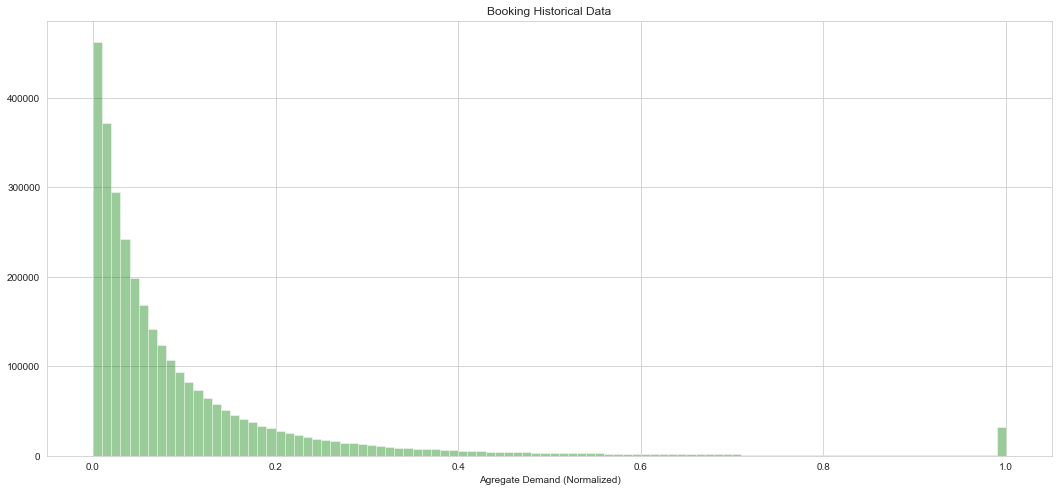

In [31]:
plt.figure(figsize = (18, 8))
sns.distplot(trainset['demand'],bins=100, kde=False,color='g')
plt.xlabel('Agregate Demand (Normalized)')
plt.title('Booking Historical Data')

2. Visualize the demand versus time chart to see the insight. The aggregate demand is high during time 0 to 10 and lowest around time 20. It rapidly increase after time 20.

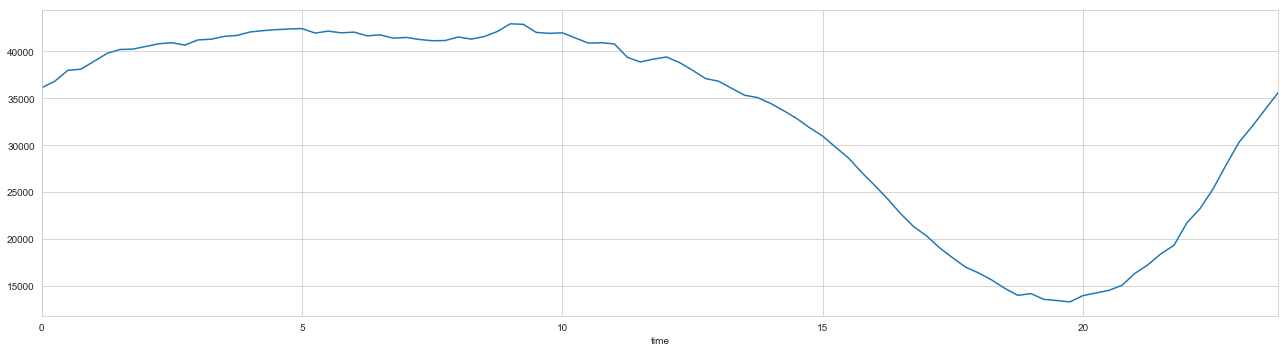

In [32]:
plt.figure(figsize=(18,5))
trainset.groupby('time').count()['demand'].plot()
plt.tight_layout()

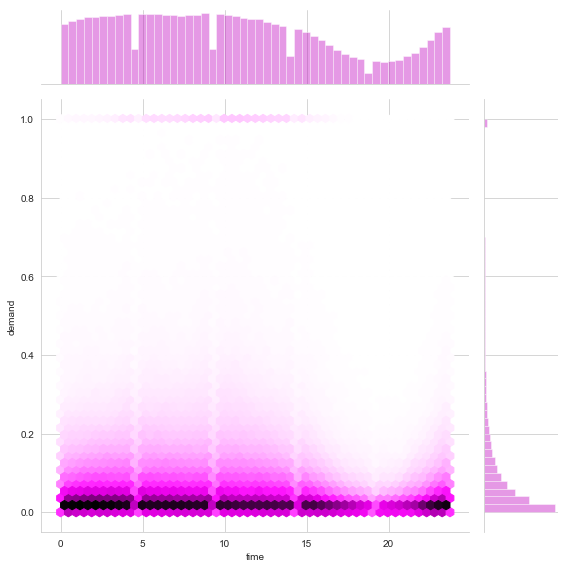

In [33]:
sns.jointplot(x='time',y='demand',data=trainset,kind='hex',height=8, color="m")


3. Visualize the demand versus day chart to see the insight. The average aggregate demand for first 30 days are slightly lower especially around day 17 and day 18. If we want to know what is happening on that day, further investigation required.

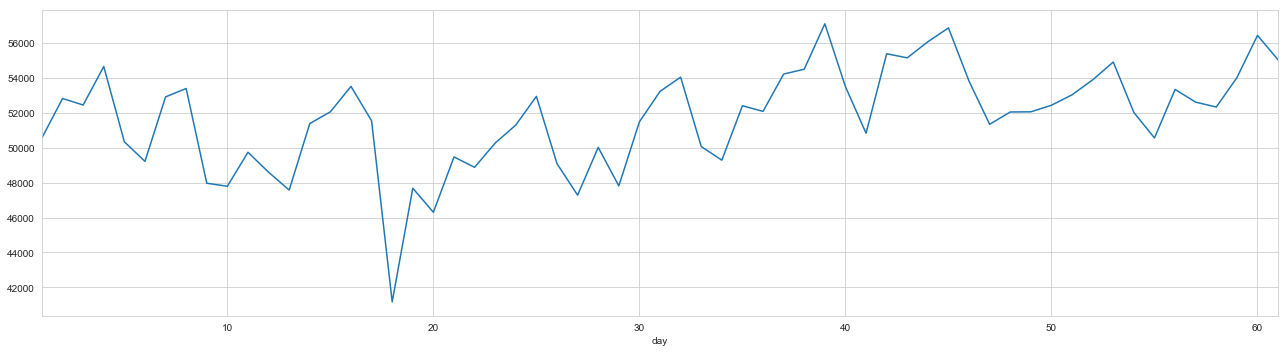

In [34]:
plt.figure(figsize=(18,5))
trainset.groupby('day').count()['demand'].plot()
plt.tight_layout()

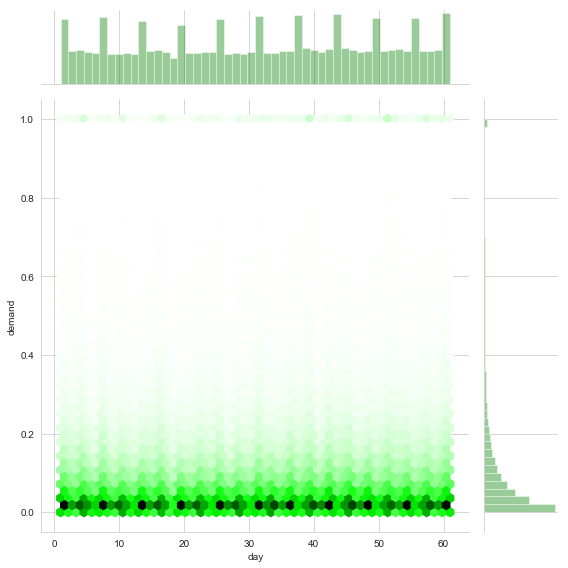

In [35]:
sns.jointplot(x='day',y='demand',data=trainset,kind='hex',height=8, color="g")


4. Visualize the demand versus latitude coordinate to find the insight. We will use heatmap for latitude and longtitude.

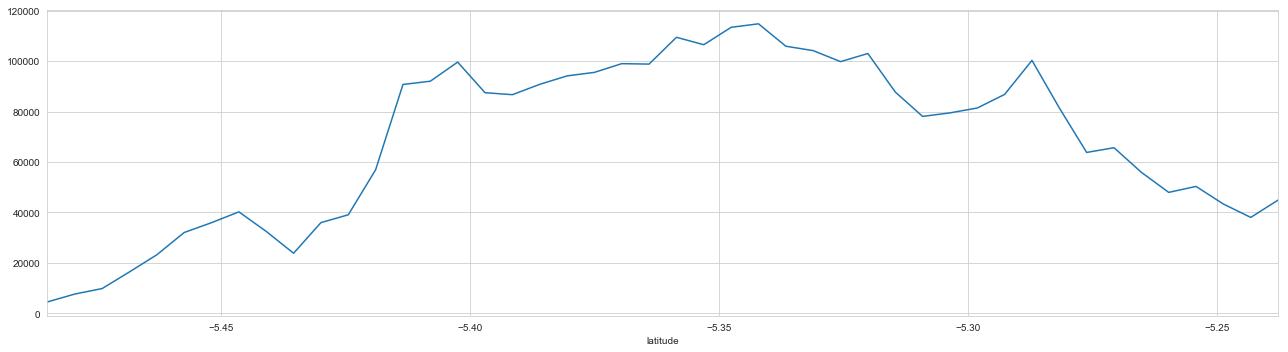

In [36]:
plt.figure(figsize=(18,5))
trainset.groupby('latitude').count()['demand'].plot()
plt.tight_layout()

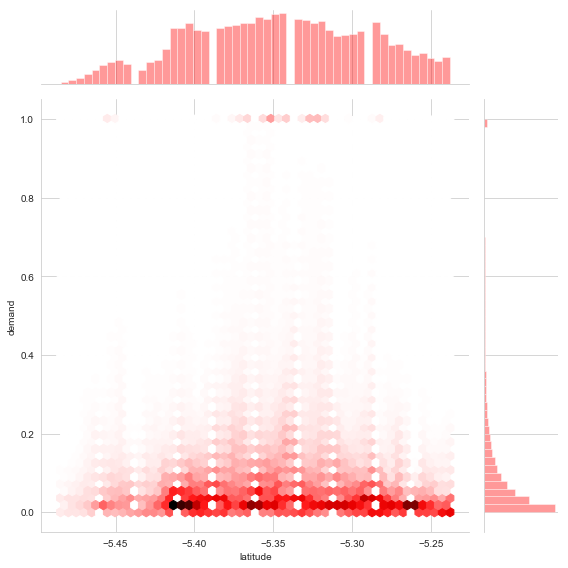

In [37]:
sns.jointplot(x='latitude',y='demand',data=trainset,kind='hex',height=8, color="r")


5. Visualize the demand versus longtitude coordinate to find the insight. We will use heatmap for latitude and longtitude.

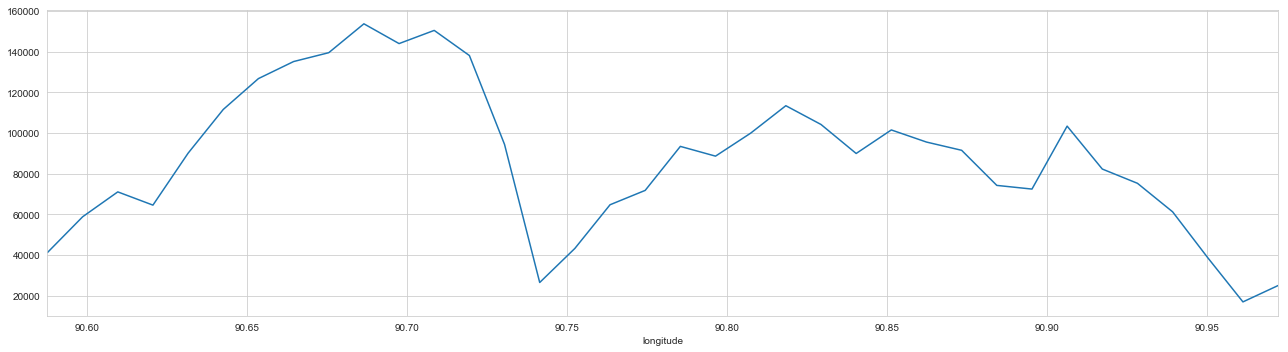

In [38]:
plt.figure(figsize=(18,5))
trainset.groupby('longitude').count()['demand'].plot()
plt.tight_layout()

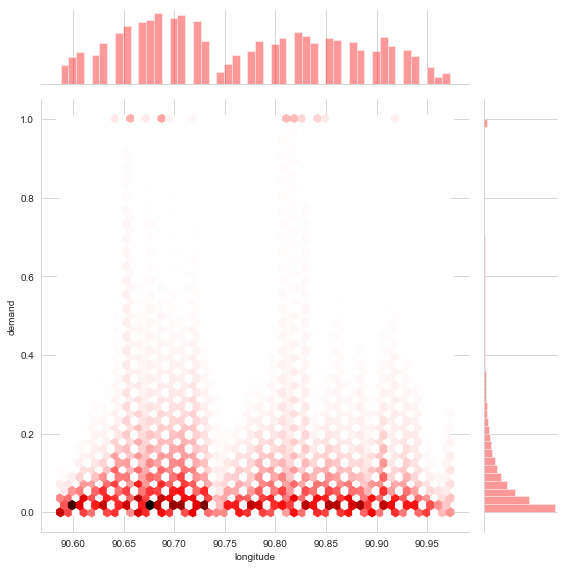

In [39]:
sns.jointplot(x='longitude',y='demand',data=trainset,kind='hex',height=8, color="r")


6. To see if the hour and minute have any relation to the demand. Hour mostly has the same shape as time. The minute plot shows the peaks of demand is during 0 minute and gradually decline as minute incline.

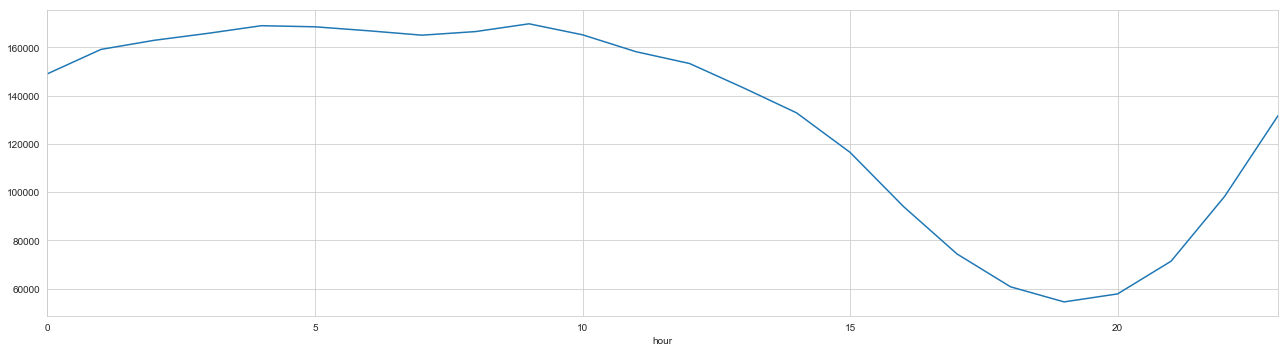

In [40]:
plt.figure(figsize=(18,5))
trainset.groupby('hour').count()['demand'].plot()
plt.tight_layout()

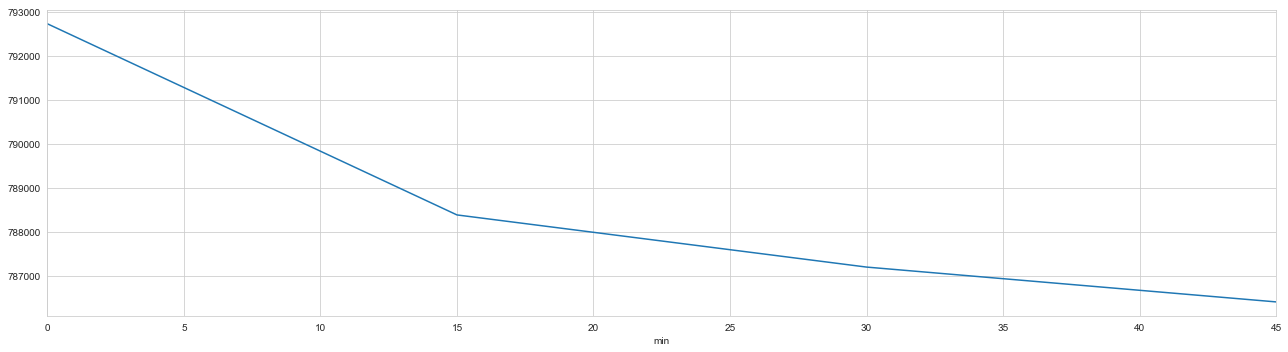

In [41]:
plt.figure(figsize=(18,5))
trainset.groupby('min').count()['demand'].plot()
plt.tight_layout()



7. In order to get heatmap, we will readjust the table and plot according to the table. From the heatmap, it seems that day 18 has outlier. We have to check other factor to verify such as what is happening on day 18.

In [42]:
dayTime = trainset.groupby(by=['day','time']).count()['demand'].unstack()
dayTime.head(10)

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.5,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75
day,,,,,,,,,,,,,,,,,,,,,
1,434.0,473.0,491.0,515.0,539.0,592.0,618.0,616.0,626.0,642.0,...,333.0,376.0,430.0,472.0,505.0,580.0,613.0,644.0,671.0,691.0
2,698.0,695.0,734.0,722.0,686.0,722.0,707.0,712.0,699.0,707.0,...,296.0,331.0,388.0,424.0,463.0,525.0,589.0,623.0,640.0,676.0
3,670.0,674.0,680.0,669.0,686.0,689.0,679.0,698.0,691.0,713.0,...,305.0,328.0,388.0,417.0,474.0,542.0,588.0,619.0,644.0,649.0
4,687.0,673.0,670.0,705.0,676.0,692.0,689.0,696.0,680.0,676.0,...,281.0,286.0,300.0,332.0,362.0,400.0,453.0,480.0,530.0,592.0
5,539.0,579.0,598.0,587.0,625.0,612.0,652.0,641.0,642.0,677.0,...,226.0,237.0,246.0,278.0,276.0,313.0,368.0,387.0,427.0,440.0
6,468.0,493.0,528.0,533.0,569.0,600.0,604.0,623.0,606.0,631.0,...,295.0,336.0,376.0,445.0,494.0,553.0,590.0,603.0,634.0,664.0
7,683.0,676.0,691.0,691.0,678.0,693.0,707.0,695.0,684.0,693.0,...,309.0,337.0,393.0,412.0,457.0,526.0,558.0,592.0,615.0,686.0
8,671.0,673.0,671.0,677.0,707.0,700.0,723.0,680.0,715.0,717.0,...,325.0,340.0,377.0,386.0,417.0,429.0,458.0,491.0,495.0,574.0
9,547.0,552.0,590.0,603.0,603.0,628.0,624.0,616.0,663.0,648.0,...,303.0,330.0,349.0,407.0,431.0,456.0,494.0,501.0,525.0,523.0


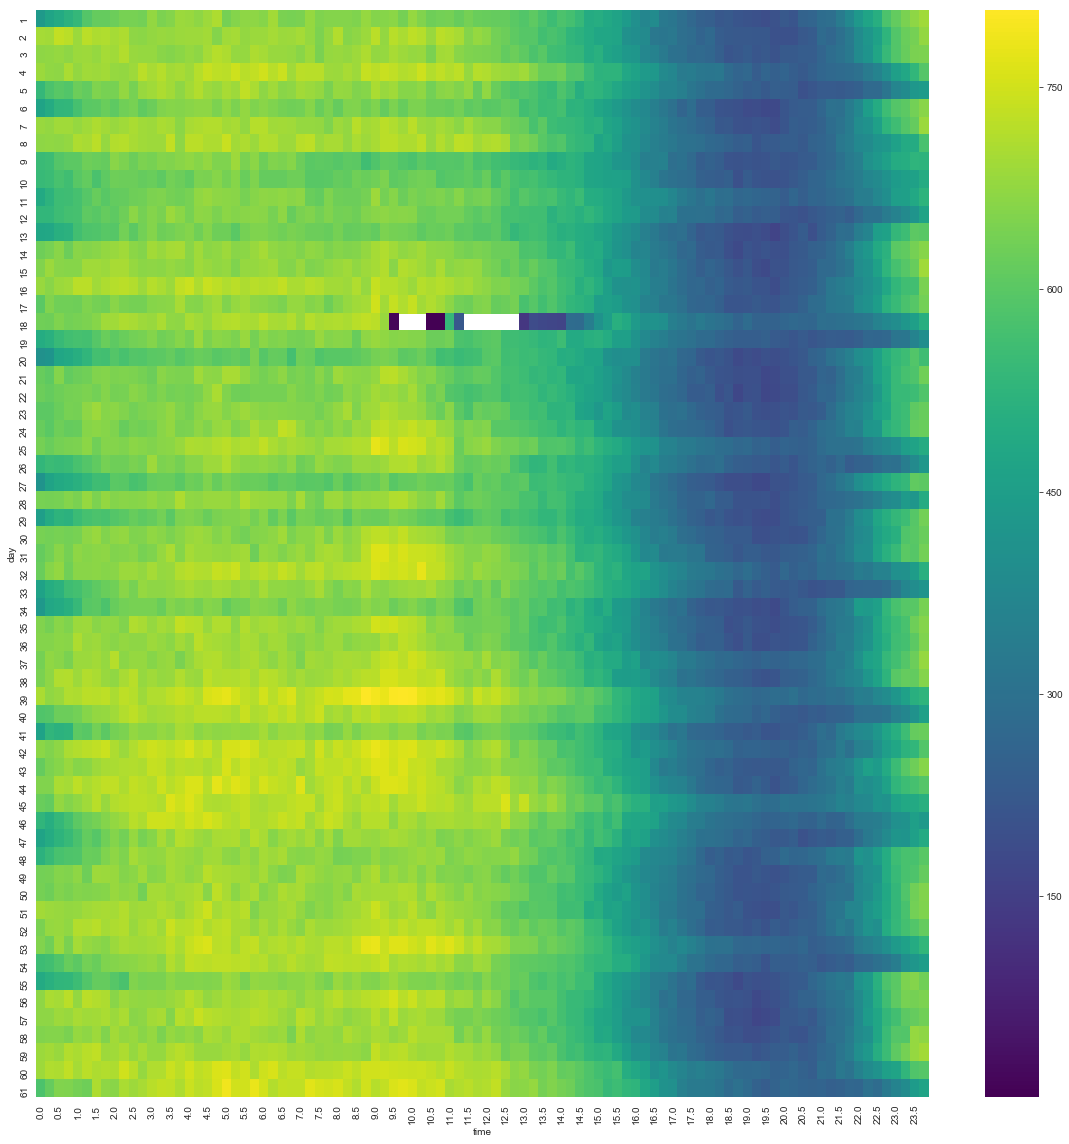

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(dayTime,cmap='viridis')

8. In order to get latitude and logtitude heatmap, we will readjust the table and plot accordingly. 

I have checked the location based on the coordinates using this [link](https://www.openstreetmap.org/), it located at the Indian Ocean near Indonesia's Sumatra which doesn't make sense.

In [44]:
latLon = trainset.groupby(by=['latitude','longitude']).count()['demand'].unstack()
latLon.head(10)

longitude,90.5877685546875,90.5987548828125,90.6097412109375,90.6207275390625,90.6317138671875,90.6427001953125,90.6536865234375,90.6646728515625,90.6756591796875,90.6866455078125,...,90.8734130859375,90.8843994140625,90.8953857421875,90.9063720703125,90.9173583984375,90.9283447265625,90.9393310546875,90.9503173828125,90.9613037109375,90.9722900390625
latitude,,,,,,,,,,,,,,,,,,,,,
-5.484924,NaN,NaN,NaN,NaN,NaN,NaN,430.0,873.0,424.0,881.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.479431,NaN,NaN,NaN,NaN,NaN,NaN,67.0,351.0,1367.0,1799.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.473938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1118.0,1823.0,2261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.468445,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2229.0,1737.0,2207.0,...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.462952,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2438.0,2304.0,3527.0,...,656.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.457458,NaN,NaN,NaN,NaN,NaN,NaN,74.0,2497.0,1938.0,3297.0,...,1366.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.451965,NaN,NaN,NaN,NaN,NaN,NaN,643.0,2329.0,2626.0,3265.0,...,3271.0,286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.446472,NaN,NaN,NaN,NaN,NaN,NaN,2120.0,1085.0,2791.0,2826.0,...,3026.0,2295.0,NaN,NaN,NaN,NaN,NaN,NaN,75.0,14.0
-5.440979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1106.0,2422.0,2437.0,...,2306.0,76.0,3.0,NaN,NaN,NaN,NaN,12.0,49.0,10.0


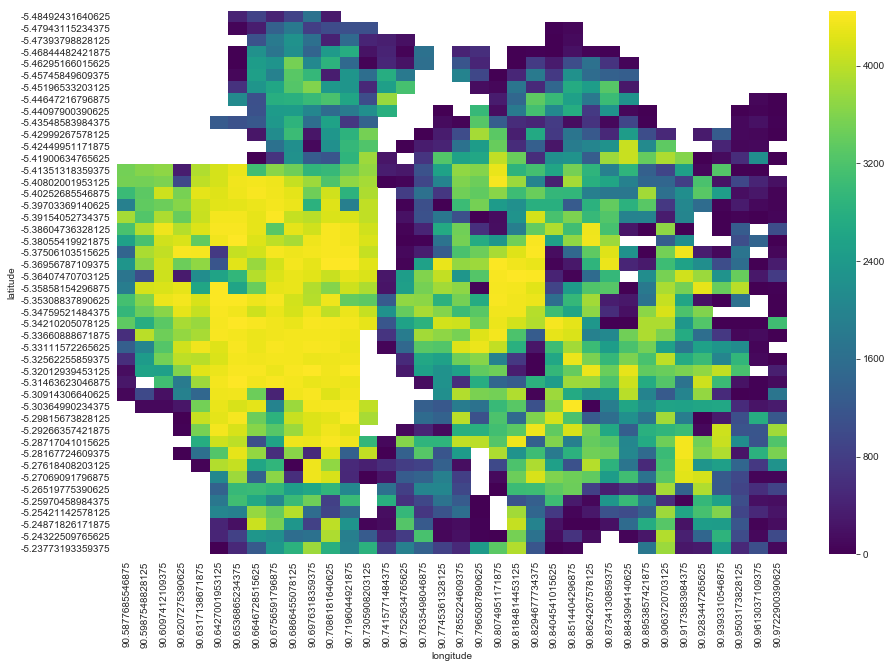

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(latLon,cmap='viridis')

9. Visualize the coordinate into Map to understand and investigate the location but turns out the location were masked into Indian Ocean near Indonesia's Sumatra. So, we unable to do much on the map plotting. 

In [49]:
# The bounding box is determined using openstreetmap: min long, min lat, max long, max lat
bbox = (89.00, 119.31,-9.15, 10.17)
sea_map = plt.imread("map2.png")

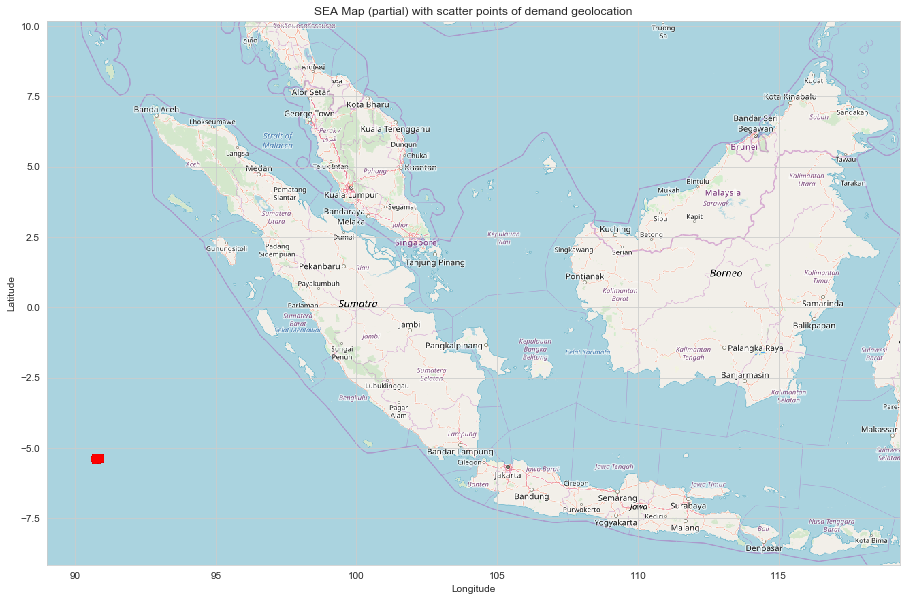

In [50]:
alpha=0.3
s=1
fig, ax = plt.subplots(1, 1, figsize=(18,10))
ax.scatter(trainset['longitude'],trainset['latitude'], zorder=1, alpha=alpha, c='r', s=s)
ax.set_xlim((bbox[0], bbox[1]))
ax.set_ylim((bbox[2], bbox[3]))
ax.set_title('SEA Map (partial) with scatter points of demand geolocation')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.imshow(sea_map, zorder=0, extent=bbox)
plt.show()

___

## Setting up the Train Test Data

**Get data ready for the regression models.**


Check data info again

In [46]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 10 columns):
geohash6      1051581 non-null object
day           1051581 non-null int64
timestamp     1051581 non-null object
demand        1051581 non-null float64
hour          1051581 non-null int64
min           1051581 non-null int64
time          1051581 non-null float64
coordinate    1051581 non-null object
latitude      1051581 non-null float64
longitude     1051581 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 80.2+ MB


In [47]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154740 entries, 0 to 3154739
Data columns (total 10 columns):
geohash6      object
day           int64
timestamp     object
demand        float64
hour          int64
min           int64
time          float64
coordinate    object
latitude      float64
longitude     float64
dtypes: float64(4), int64(3), object(3)
memory usage: 240.7+ MB


In [10]:
X_train = trainset[['time','day','latitude','longitude']].values
y_train = trainset['demand'].values

In [11]:
X_test = testset[['time','day','latitude','longitude']].values
y_test = testset['demand'].values

In [50]:
print(X_train.shape)
print(y_train.shape)

(3154740, 4)
(3154740,)


In [51]:
print(X_test.shape)
print(y_test.shape)

(1051581, 4)
(1051581,)


___

# Decision Tree Model 

## Training a Decision Tree Model

Start by training a single decision tree first!

**Import DecisionTreeRegressor**

In [52]:
# Fitting the Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor

In [53]:
tree = DecisionTreeRegressor(random_state=0)

In [54]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

## Predictions and Evaluation of Decision Tree
Predict the test data and evaluate the model

- MAE: A metric which is sensitive to outliers due to the fact that it is a mean. It is calculated by taking the mean value of the absolute differences between the predicted and true values of y.

- MSE: It penalizes outliers due to its squared component. It is calculated as the average of the squares of the difference between the predicted and true values of y.

- RMSE (Root mean squared error): Commonly used as an evaluation metric in regression problems. It is calculated by taking the square root of Mean Squared Error. Conveniently, the RMSE as the same units as the quantity estimated (y).

**Create predictions from the test set and create a Mean Absolute Error, Mean Squared Error and Root Mean Square Error.**

In [55]:
# Predicting a decision tree result
tree_pred = tree.predict(X_test)
tree_score = tree.score(X_test, y_test)
print(tree_score)

0.9344795352062237


In [56]:
# calculate tree MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, tree_pred))
print('MSE:', metrics.mean_squared_error(y_test, tree_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))

MAE: 0.025578539505139407
MSE: 0.0016550187341871118
RMSE: 0.04068192146626203




### Decision Tree model looks good but we have to do some validation to test performance and overfitting.

___

## Cross-validation Analysis
** Let's set up some cross-validation analysis to evaluate our model and later models **

We will go for a very simple decision tree regression first. We can **test for performance and overfitting** using k-fold validation; here we take  k=10. 

In [57]:
from sklearn.model_selection import cross_val_score

Explained Variance as a Performance Metric
For now, we use explained variance,  EV , as a metric to evaluate the performance of a model:

EV=1−Var(y−y¯)/Var(y)

where  y  is the true output,  y¯  is the estimated output from the model, and  Var(⋅)  is the variance. The  y¯  estimates come from predictions made on the data witheld from training in each round of cross-validation. See: http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

The best possible score is 1.0, lower values are worse.

In [58]:
scores_dtr = cross_val_score(tree, X_train, y_train, cv=10,scoring='explained_variance', n_jobs= -1)

In [59]:
print('Scores for k=10 fold validation:',scores_dtr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (scores_dtr.mean(), scores_dtr.std() * 2))

Scores for k=10 fold validation: [0.81770364 0.70147719 0.70027198 0.76811887 0.73739113 0.79340364
 0.7566938  0.71016453 0.78846888 0.75633628]
Estimated EV: 0.7530 (+/- 0.0771)


In [60]:
scores_rmse_dtr = cross_val_score(tree, X_train, y_train, cv=10,scoring='neg_mean_squared_error', n_jobs= -1)

In [61]:
print('Scores for k=10 fold validation:',scores_rmse_dtr)
print("MSE: %0.4f (+/- %0.4f)" % (scores_rmse_dtr.mean(), scores_rmse_dtr.std() * 2))

Scores for k=10 fold validation: [-0.00445157 -0.00729421 -0.00788835 -0.00534201 -0.00644873 -0.00545768
 -0.00644441 -0.00741728 -0.00618843 -0.00743116]
MSE: -0.0064 (+/- 0.0021)


In [62]:
print("RMSE: %0.4f" % math.sqrt(-(scores_rmse_dtr.mean())))

RMSE: 0.0802


**The Decision Tree Regressor: Not a good Model**

This is not good because explained variance is 0.75 and RMSE is 0.0802, the performance is not optimum.

___

## Let's find the Best Model using Grid Search Cross Validation

**Find the best parameters for Decision Tree**

### Grid Search
with 10 folds, cv = 10

In [28]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = dict(max_depth=[10,20,30],
                  min_samples_leaf=[30,40,60,80]
                 )

In [30]:
grid_search = GridSearchCV(estimator=tree, 
                           param_grid=param_grid,
                           scoring = 'neg_mean_squared_error',
                           cv = 10,
                           n_jobs=-1
                           )

In [31]:
grid_search = grid_search.fit(X_train, y_train)

In [33]:
print("grid.best_score(MSE): {}".format(grid_search.best_score_))
print("grid.best_params: {}".format(grid_search.best_params_))
print("grid.best_estimator: {}".format(grid_search.best_estimator_))  
print("grid.n_splits: {}".format(grid_search.n_splits_)) 

grid.best_score(MSE): -0.004246590746479982
grid.best_params: {'max_depth': 20, 'min_samples_leaf': 80}
grid.best_estimator: DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=80,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')
grid.n_splits: 10


In [38]:
math.sqrt(-(grid_search.best_score_))

0.06516587102525356

Max_depth of 20 and min samples leaf of 80 have improved the RMSE to 0.0652.

**So let's set new model with this setting, Max_depth = 20, min_samples_leaf = 80**

___

## New Decision Tree
Set up a new parameter for the new decision tree based on the grid search, max depth = 20 and min samples leaf = 80

In [63]:
new_tree = DecisionTreeRegressor(random_state=0, max_depth=20,min_samples_leaf=80)

In [64]:
new_tree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=80,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

### Cross Validation for new Decision Tree model

In [65]:
new_scores_dtr = cross_val_score(new_tree, X_train, y_train, cv=10,scoring='explained_variance', n_jobs= -1)

In [66]:
print('Scores for k=10 fold validation:',new_scores_dtr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (new_scores_dtr.mean(), new_scores_dtr.std() * 2))

Scores for k=10 fold validation: [0.84776975 0.80228103 0.8113797  0.85623627 0.85975916 0.85122572
 0.82705194 0.79305722 0.82359683 0.84791261]
Estimated EV: 0.8320 (+/- 0.0454)


In [67]:
new_rmse_dtr = cross_val_score(new_tree, X_train, y_train, cv=10,scoring='neg_mean_squared_error', n_jobs= -1)
print('Scores for k=10 fold validation:',new_rmse_dtr)
print("MSE: %0.4f (+/- %0.4f)" % (new_rmse_dtr.mean(), new_rmse_dtr.std() * 2))

Scores for k=10 fold validation: [-0.00370101 -0.00476777 -0.00470049 -0.00326667 -0.00334815 -0.00378581
 -0.00455968 -0.00530819 -0.00516677 -0.00443997]
MSE: -0.0043 (+/- 0.0014)


In [68]:
print("RMSE: %0.4f" % math.sqrt(-(new_rmse_dtr.mean())))

RMSE: 0.0656


### New Prediction for new Decision Tree test dataset

In [69]:
# Predicting a decision tree result
new_tree_pred = new_tree.predict(X_test)
new_tree_score = new_tree.score(X_test, y_test)
print(new_tree_score)

0.8761336631779827


In [70]:
# calculate tree MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, new_tree_pred))
print('MSE:', metrics.mean_squared_error(y_test, new_tree_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, new_tree_pred)))

MAE: 0.03109952020199314
MSE: 0.003128810343772809
RMSE: 0.055935769805847926


### Residual
Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(-0.2, 0.2)

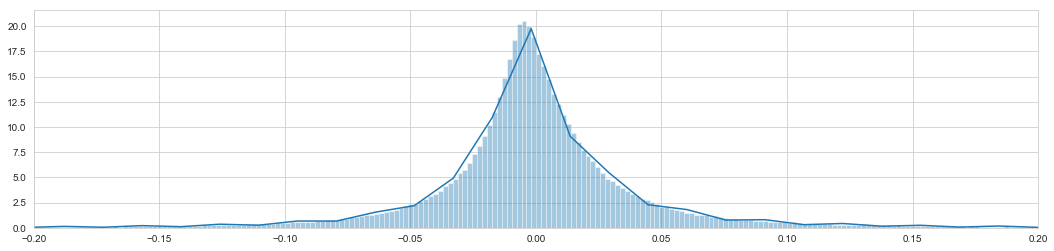

In [71]:
plt.figure(figsize=(18,4))
sns.distplot((y_test-new_tree_pred), bins=1000);
plt.xlim(-0.2,0.2)
#plt.ylim(0,20)

Based on the new cross validation, the RMSE is 0.0656.

Based on the new prediction, the RMSE is 0.0559

Is decision tree regressor model good enough? Decision Tree is prone to overfitting.

What if we consider an ensemble of trees?

Let's use a **Random Forest Regressor** and test it out. We will consider forests with varying numbers of trees (estimators), each of which provides a weak regression solution that can be averaged to get the overall regression output. See: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

___

# Random Forest Model

## Training the Random Forest model

Train the model with random forest regressor starting with n_estimators = 10

**Create an instance of the RandomForestRegressor class and fit it to training data.**

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
forest = RandomForestRegressor(n_estimators=10, n_jobs = -1)

In [74]:
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Predictions of Random Forest

Let's predict with the initial setting of n_estimator =10 first.
- MAE: A metric which is sensitive to outliers due to the fact that it is a mean. It is calculated by taking the mean value of the absolute differences between the predicted and true values of y.

- MSE: It penalizes outliers due to its squared component. It is calculated as the average of the squares of the difference between the predicted and true values of y.

- RMSE (Root mean squared error): Commonly used as an evaluation metric in regression problems. It is calculated by taking the square root of Mean Squared Error. Conveniently, the RMSE as the same units as the quantity estimated (y).

**Create predictions from the test set and create a Mean Absolute Error, Mean Squared Error and Root Mean Square Error.**

In [75]:
# Predicting a random forest result
forest_pred = forest.predict(X_test)
forest_score = forest.score(X_test, y_test)
print(forest_score)

0.9565518250426899


In [76]:
# calculate forest MAE, MSE, RMSE! (n_estimators=10)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, forest_pred))
print('MSE:', metrics.mean_squared_error(y_test, forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, forest_pred)))

MAE: 0.021295455120529192
MSE: 0.0010974821950197452
RMSE: 0.0331282688201443


The predicted test value of score, MAE, MSE and RMSE have better result than Decision Tree. (n_estimators=10)

The best possible score is 1 and the lesser the RMSE, the better the model is.

### The score of 0.957 is better than Decision Tree and RMSE of 0.0331 is better than Decision Tree as well. But we have to do some validation to test performance and overfitting.

___

## Cross-Validation for Random Forest model

### Let's set up some cross-validation analysis to evaluate our model and later models
We will go for a very simple decision tree regression first. We can test for performance and overfitting using k-fold validation; here we take  k=10. 

In [77]:
from sklearn.model_selection import cross_val_score

In [78]:
scores_rfr = cross_val_score(forest, X_train, y_train, cv=10, scoring='explained_variance')

Explained Variance as a Performance Metric
For now, we use explained variance,  EV , as a metric to evaluate the performance of a model:

EV=1−Var(y−y¯)/Var(y)

where  y  is the true output,  y¯  is the estimated output from the model, and  Var(⋅)  is the variance. The  y¯  estimates come from predictions made on the data witheld from training in each round of cross-validation. See: http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

The best possible score is 1.0, lower values are worse.

In [79]:
print('Scores for k=10 fold validation:',scores_rfr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (scores_rfr.mean(), scores_rfr.std() * 20))

Scores for k=10 fold validation: [0.83540046 0.73007305 0.72606158 0.79529388 0.77520603 0.82420113
 0.78189959 0.74741621 0.80891296 0.78243897]
Estimated EV: 0.7807 (+/- 0.7095)


In [80]:
score_rmse_rfr = cross_val_score(forest, X_train, y_train, cv=10,scoring='neg_mean_squared_error')

In [81]:
print('Scores for k=10 fold validation:',score_rmse_rfr)
print("MSE: %0.4f (+/- %0.4f)" % (score_rmse_rfr.mean(), score_rmse_rfr.std() * 2))

Scores for k=10 fold validation: [-0.00402289 -0.00657307 -0.00722902 -0.00475376 -0.00555448 -0.00467459
 -0.00576277 -0.00646929 -0.00559674 -0.00659016]
MSE: -0.0057 (+/- 0.0019)


In [82]:
print("RMSE: %0.4f" % math.sqrt(-(score_rmse_rfr.mean())))

RMSE: 0.0756


**The Random Forest Regressor: Not good**

The results obtained is bad. For explained variance of 0.78, the best possible result is 1 and RMSE is 0.0756. Let's find the optimum parameter for random forest.

___

## Find the best Random Forest Model
Previously we use n_estimators = 10 only. Here we find the best estimator for the random forest model. 


I have run a series of n_estimator number using spyder. To rerun the code in Jupyter is time consume therefore I attached this photo from the spyder and the code is as below.

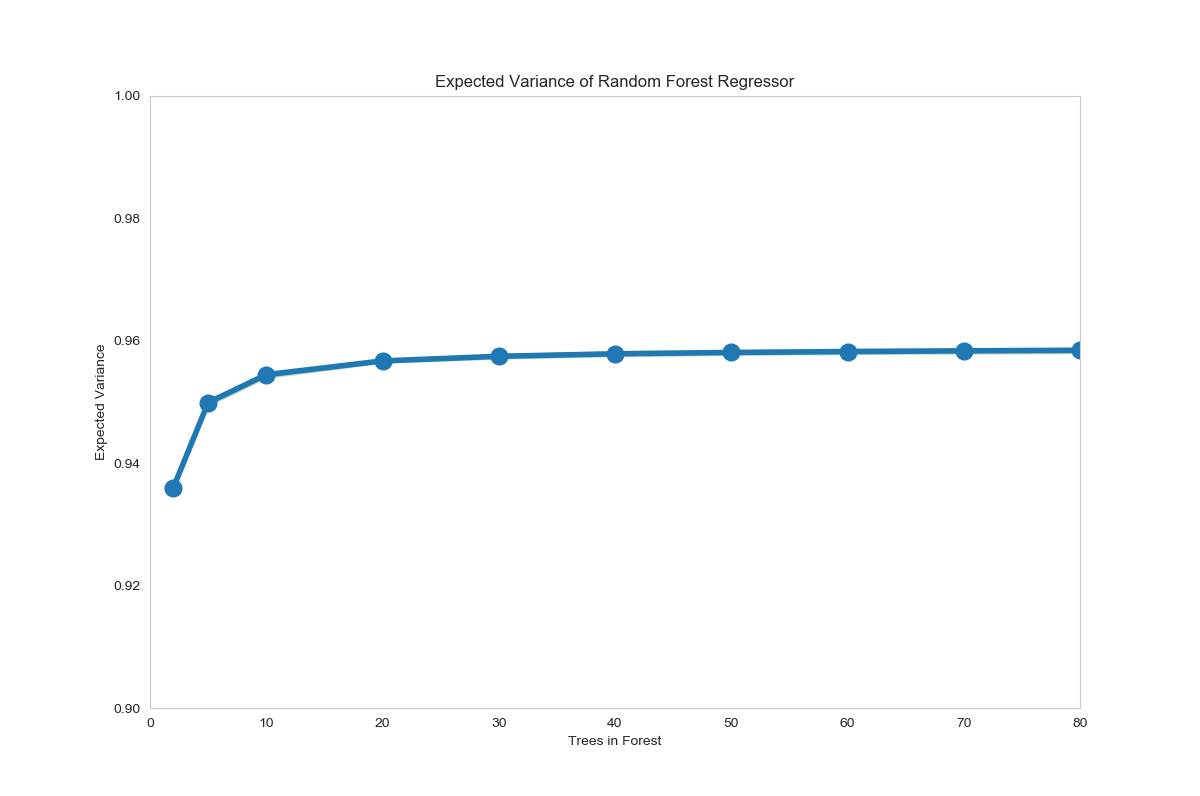

In [148]:
from sklearn.ensemble import RandomForestRegressor as rfr

In [ ]:
estimators = [2,5,10,20,30,80]
mean_rfrs = []
std_rfrs_upper = []
std_rfrs_lower = []
yt = [i for i in y_train] # quick pre-processing of the target
np.random.seed(11111)

In [ ]:
for i in estimators:
    model = rfr(n_estimators=i,max_depth=None,random_state=0,n_jobs= -1)
    scores_rfr = cross_val_score(model,X_train,yt,cv=10,scoring='explained_variance')
    print('estimators:',i)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. explained variance: %0.2f (+/- %0.2f)" % (scores_rfr.mean(), scores_rfr.std() * 20))
    print('')
    mean_rfrs.append(scores_rfr.mean())
    std_rfrs_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    std_rfrs_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting

In [ ]:
# and plot...
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(estimators,mean_rfrs,marker='o',
       linewidth=4,markersize=12)
ax.fill_between(estimators,std_rfrs_lower,std_rfrs_upper,
                facecolor='green',alpha=0.3,interpolate=True)
ax.set_ylim([0,1])
ax.set_xlim([0,80])
plt.title('Expected Variance of Random Forest Regressor')
plt.ylabel('Expected Variance')
plt.xlabel('Trees in Forest')
plt.grid()
plt.show()

From the result or the chart above, the best estomators is 0.96 and it stop when reaching 30 trees. Therefore, **n_estimators = 30**.

**Continue find the best parameter using grid search cross validation**

In [15]:
from sklearn.model_selection import GridSearchCV

In [100]:
param_grid = dict(max_depth=[5,10,20,40,60,100],
                  min_samples_leaf=[1,2,4,8,16])

grid = GridSearchCV(forest, param_grid, cv=10,
                    scoring='neg_mean_squared_error',n_jobs= -1)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print("grid.cv_results_ {}".format(grid.cv_results_))

In [ ]:
print("grid.best_score: {}".format(grid.best_score_))
print("grid.best_params: {}".format(grid.best_params_))
print("grid.best_estimator: {}".format(grid.best_estimator_))
print("grid.n_splits: {}".format(grid.n_splits_))  

The best parameters are n_estimator = 30, max_depth = 40 and min_samples_leaf = 2

### After getting the best parameter, set up a new random forest model.

___

## New Random Forest Model

Set up a new parameter for the new random forest model based on the grid search, **n_estimator =30**, **max_depth = 40** and **min_samples_leaf = 2**.

In [13]:
new_forest = RandomForestRegressor(n_estimators=30,max_depth=40,min_samples_leaf=2, n_jobs= -1)

In [14]:
new_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Cross Validation for new Random Forest model

In [15]:
from sklearn.model_selection import cross_val_score

In [16]:
new_scores_rfr = cross_val_score(new_forest, X_train, y_train, cv=10, scoring='explained_variance')

In [17]:
print('Scores for k=10 fold validation:',new_scores_rfr)
print("Estimated EV: %0.4f (+/- %0.4f)" % (new_scores_rfr.mean(), new_scores_rfr.std() * 2))

Scores for k=10 fold validation: [0.95548588 0.95556447 0.95606693 0.95583615 0.95542723 0.95599478
 0.95574413 0.95590705 0.95559601 0.95581935]
Estimated EV: 0.9557 (+/- 0.0004)


In [18]:
new_rmse_rfr = cross_val_score(new_forest, X_train, y_train, cv=10,scoring='neg_mean_squared_error')

In [19]:
print('Scores for k=10 fold validation:',new_rmse_rfr)
print("MSE: %0.4f (+/- %0.4f)" % (new_rmse_rfr.mean(), new_rmse_rfr.std() * 2))

Scores for k=10 fold validation: [-0.00114232 -0.00112757 -0.00111485 -0.00112634 -0.00113081 -0.00112296
 -0.00112277 -0.00111752 -0.00112129 -0.00110961]
MSE: -0.0011 (+/- 0.0000)


In [20]:
math.sqrt(-(new_rmse_rfr.mean()))

0.033520221177638684

### New Prediction for New Random Forest test dataset

In [21]:
# Predicting a random forest result
new_forest_pred = new_forest.predict(X_test)
new_forest_score = new_forest.score(X_test, y_test)
print(new_forest_score)

0.9577259749883867


In [22]:
# calculate forest MAE, MSE, RMSE!
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, new_forest_pred))
print('MSE:', metrics.mean_squared_error(y_test, new_forest_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, new_forest_pred)))

MAE: 0.020797808573401116
MSE: 0.0010678236728619824
RMSE: 0.032677571403976494


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

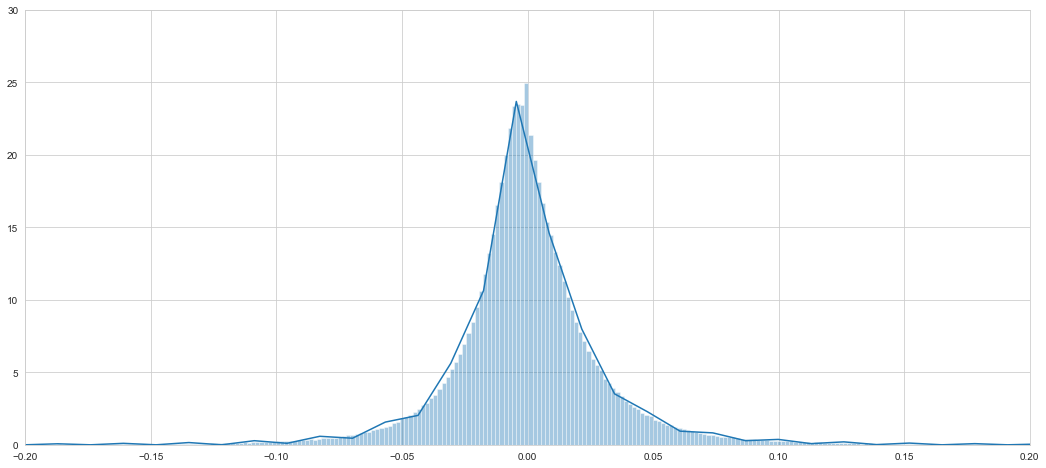

In [23]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-new_forest_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

The table shown is the results for Decision Tree and Random Forest:

| Models                 | Decision Tree   | Random Forest |
|------------------------|-----------------|---------------|
|CV Train RMSE:          | 0.0656          | 0.0335        |
|Prediction RMSE:        | 0.0559          | 0.0327        |


### The results above shown Random Forest is definitely a better model .
This is because the decision tree only consists of "a tree" and it cross validate the data of "a tree" only. 

For random forest, the model is ensemble of trees, where it correct for decision trees' habit of overfitting to their training set. Ensemble methods by random forest use multiple learning models to gain better predictive results. In the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.
Cross validate the ensemble of tree can further verify the accuracy of the model.

**Although random forest has a great results, but we have to test with more dataset and with different input in order to find the bias and variance of this random forest model.**

### Is Random Forest the best model? Next, let's try Extreme Gradient Boosting.

___

## eXtreme Gradient Boost - XGBoost model

### Train the XGBoost model

To start, import the XGBoost library and neccessary library. 

In [12]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

### Tune the model to find the best parameter

In [13]:
# Start with standard parameter
xgb1 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    n_jobs=-1,
                    nthread=96,
                    scale_pos_weight=1,
                    seed=27)
xgb1.fit(X_train, y_train)

scores_xgb1 = cross_val_score(xgb1, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('Scores for k=10 fold validation:',scores_xgb1)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb1.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb1.mean())))

In [ ]:
# Fix learning rate and no. estimators
param_test1 = {
    'max_depth':[7,9,10,15,20],
    'min_child_weight':[3,5,7,9,12]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=96,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)

gsearch1.best_params_
gsearch1.best_score_

In [ ]:
# Tune max depth and min child weight
param_test1b = {
    'max_depth':[40,60,100]
}
gsearch1b = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 5,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test1b, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch1b.fit(X_train,y_train)

print('Best param:', gsearch1b.best_params_)
print('Best scores:', gsearch1b.best_score_)

In [ ]:
# Tune gamma
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

print('Best param:', gsearch3.best_params_)
print('Best scores:', gsearch3.best_score_)

In [ ]:
# Tune subsample and colsample by tree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

print('Best param:', gsearch4.best_params_)
print('Best scores:', gsearch4.best_score_)

In [ ]:
# Tune regularization parameter
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

print('Best param:', gsearch5.best_params_)
print('Best scores:', gsearch5.best_score_)

In [ ]:
# Minor Tune, check the result previously
param_test6 = {
    'reg_alpha':[0.05, 0.1, 0.15, 0.2, 0.3]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(X_train,y_train)

print('Best param:', gsearch6.best_params_)
print('Best scores:', gsearch6.best_score_)

In [ ]:
# Tune estimators and learning rate
param_test7 = {
    'n_estimators':[50,100,200],
    'learning_rate':[0.01, 0.1, 0.2]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27),
                       param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch7.fit(X_train,y_train)

print('Best param:', gsearch7.best_params_)
print('Best scores:', gsearch7.best_score_)

In [ ]:
# Tune estimators and learning rate
param_test8 = {
    'n_estimators':[200,300,500],
    'learning_rate':[0.01, 0.1, 0.15]
}
gsearch8 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27),
                       param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(X_train,y_train)

print('Best param:', gsearch8.best_params_)
print('Best scores:', gsearch8.best_score_)

### The best parameters from tuning are:
* gamma = 0
* min_child_weight = 5
* max_depth = 60
* subsample = 0.6
* colsample_bytree = 0.8
* learning_rate = 0.1
* n_estimators = 200
* reg_alpha = 0.2


In [14]:
xgb9 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=200,
                    #nthread=4,
                    n_jobs=-1,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27)

In [15]:
xgb9.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=60,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.2,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6, tree_method='exact')

### Cross Validation for new optimum parameter of XGBoost model
This is to test performance and overfitting using k-fold validation; here we take 10 folds, cv = 10.

In [16]:
scores_xgb = cross_val_score(xgb9, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [17]:
print('Scores for k=10 fold validation:',scores_xgb)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb.mean())))

Scores for k=10 fold validation: [-0.00172954 -0.00171549 -0.00169699 -0.00171216 -0.00171941 -0.00171269
 -0.0017082  -0.00170338 -0.00172504 -0.00170892]
Train MSE: -0.001713 (+/- 0.000018)
Train RMSE: 0.041391


The XGBoost cross validation for Train RMSE is 0.0413 and Random Forest cross validation for train RMSE is 0.741.
Apparently there is great improvement of the RMSE using XGBoost.

Let's predict the test dataset.

### Prediction for test dataset

In [18]:
xgb9_score = xgb9.score(X_test, y_test)
print("Prediction Score: %0.6f" % xgb9_score)

Prediction Score: 0.932505


In [19]:
# Predicting a rgb result
xgb9_pred = xgb9.predict(X_test)
from sklearn import metrics
print('Test MAE:', metrics.mean_absolute_error(y_test, xgb9_pred))
print('Test MSE:', metrics.mean_squared_error(y_test, xgb9_pred))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb9_pred)))

Test MAE: 0.026864358501950906
Test MSE: 0.0017048931398081807
Test RMSE: 0.041290351655177034


The cross validation of test RMSE value is close to train RMSE.

The table shows the results of XGBoost:

| Models                 | **XGBoost** |
|------------------------|-------------|
|CV Train RMSE:          | **0.0414**  |
|Prediction RMSE:        | **0.0410**  |


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

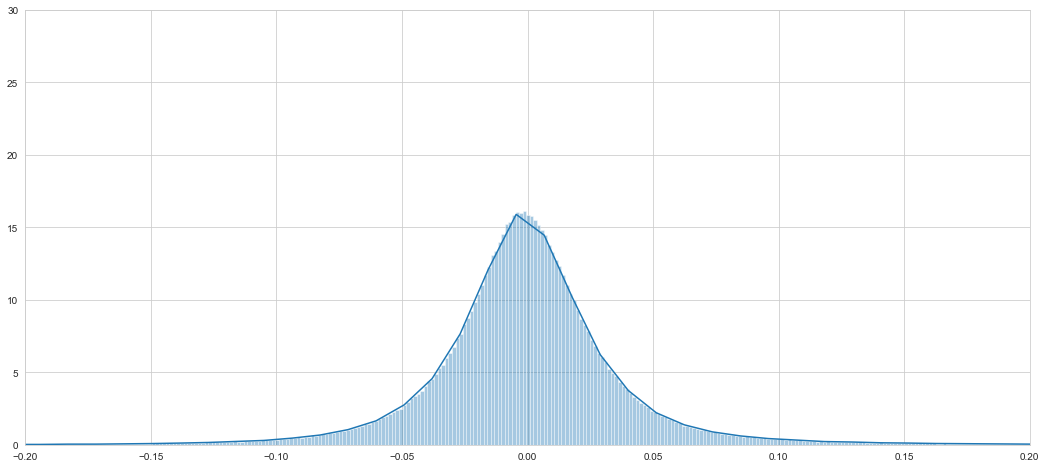

In [20]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-xgb9_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

### Visualize the features importance
There are features included: 
1. time, f0
2. day, f1
3. latitude, f2
4. longtude, f3

The result shows **time is the most important feature**.

In [21]:
print(xgb9.feature_importances_)

[0.35384938 0.26246685 0.20399931 0.17968445]


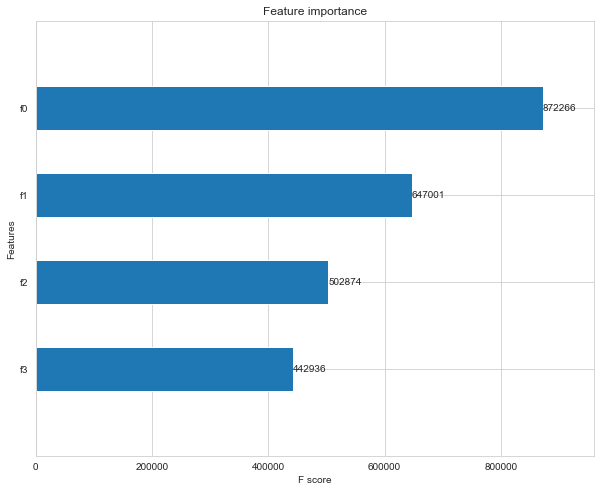

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
xgb.plot_importance(xgb9, height=0.5, ax=ax)
plt.show()

___

## Conclusion

The table compares the results of Decision Tree, Random Forest and XGBoost.

| Models                 | Decision Tree | Random Forest | **XGBoost** |
|------------------------|---------------|---------------|-------------|
|CV Train RMSE:          | 0.0656        | 0.0335        | **0.0414**  |
|Prediction RMSE:        | 0.0559        | 0.0327        | **0.0410**  |

The ideal algorithm has low bias and can accurately model the true relationship and it has low variability, by producing consistent predictions across different datasets. 

In [1]:
tree_percent_distance = ((0.0656-0.0559)/0.0656)*100
print('Tree Distance: %.2f' % tree_percent_distance)

rf_percent_distance = ((0.0335-0.0327)/0.0335)*100
print('Forest Distance: %.2f' % rf_percent_distance)

xgb_percent_distance = ((0.0414-0.0410)/0.0414)*100
print('XGBoost Distance: %.2f' % xgb_percent_distance)

Tree Distance: 14.79
Forest Distance: 2.39
XGBoost Distance: 0.97


The shortest RMSE differences between train and test is XGBoost model. The random forest has the lowest RMSE scores for train and test but XGBoost RMSE scores also has very low RMSE.

XGBoost has the lowest RMSE difference for train and test so it has consistent predictions across different datasets. XGBoost also has low train RMSE score. The three models have very low predicted RMSE and although random forest has the lowest predicted RMSE, but it has higher distance difference for train and test compare to XGBoost.

There were several analysis carried with different input in order to find the bias and variance. You may have a quick look on the quick_analysis folder in github.

Here is the results of all the analysis carried out:

1. Training data split to 80% train data and 20% test data

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0330        | **0.0414**  |
|Prediction RMSE:        | 0.0322        | **0.0413**  |

2. Training data split to train data (first 60 days) and test data (day 61)

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0312        | **0.0409**  |
|Prediction RMSE:        | 0.0735        | **0.0689**  |

3. Training data split to train data(first 60 days) and test data (day 61 timestamp 0:0) 

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0312        | **0.0409**  |
|Prediction RMSE:        | 0.0732        | **0.0708**  |

4. Training data split to train data (first 60 days) and test data (day 61, timestamp less than and equal to 0:15)

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0312        | **0.0409**  |
|Prediction RMSE:        | 0.0740        | **0.0717**  |

5. Training data split to train data (first 60 days) and test data (day 61, timestamp less than 12:00)

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0312        | **0.0409**  |
|Prediction RMSE:        | 0.0831        | **0.0768**  |

6. Training data split to train data (first 47 days) and test data (last 14 days)

| Models                 | Random Forest | **XGBoost** |
|------------------------|---------------|-------------|
|CV Train RMSE:          | 0.0308        | **0.0403**  |
|Prediction RMSE:        | 0.0870        | **0.0799**  |

7. Training data split to train data (first 60 days, 75%), test data (first 60 days, 25%) and hold out data (day 61)


| Models                 | Random Forest (test) | **XGBoost** (test) |Random Forest (hold out) | **XGBoost** (hold out) |
|------------------------|----------------------|--------------------|-------------------------|------------------------|
|CV Train RMSE:          | 0.0741               | **0.0413**         | 0.0741                  | **0.0413**             |
|Prediction RMSE:        | 0.0320               | **0.0410**         | 0.0732                  | **0.0692**             |




**In conclusion, the results show XGBoost model is the best model to achieve the objective because of its low RMSE thus low bias and the train and predicted RMSE value have close distance thus low variance.** 

## XGBoost, the best model to achieve the objective.

___

## Export the Prediction data

### Transform the time and Encode the coordinate

In [95]:
# define the data frame for the results
predict_demand = pd.DataFrame(xgb9_pred, columns=['predicted_demand'])

In [105]:
results = pd.concat([testset[['geohash6','day','timestamp']],predict_demand['predicted_demand']],axis=1)

In [118]:
results.to_csv('predicted_demand_submission.csv', index = False)

___